# Introduction: Taxi Fare Prediction

This was a Kaggle challenge. In this contest, the aim is to predict the fare of a taxi ride given the starting time, the starting and ending latitude / longitude, and the number of passengers. This is a __supervised regression__ machine learning task.

In [1]:
# Pandas and numpy for data manipulation
import pandas as pd
import numpy as np



# Visualizations
import matplotlib.pyplot as plt

import seaborn as sns

In [2]:
data = pd.read_csv('taxifare.csv')

# Remove na
data = data.dropna()
data.head()

,pickup_datetime,fare_amount,fare_class,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2010-04-19 08:17:56 UTC,6.5,0,-73.992365,40.730521,-73.975499,40.744746,1
1,2010-04-17 15:43:53 UTC,6.9,0,-73.990078,40.740558,-73.974232,40.744114,1
2,2010-04-17 11:23:26 UTC,10.1,1,-73.994149,40.751118,-73.960064,40.766235,2
3,2010-04-11 21:25:03 UTC,8.9,0,-73.990485,40.756422,-73.971205,40.748192,1
4,2010-04-17 02:19:01 UTC,19.7,1,-73.990976,40.734202,-73.905956,40.743115,1


### Describe Data

An effective method for catching outliers and anomalies is to find the summary statistics for the data using the `.describe()` method. I like to concentrate on the maxes and the minimums for finding outliers.

In [3]:
data.describe()

,fare_amount,fare_class,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,120000.000000,120000.000000,120000.000000,120000.000000,120000.000000,120000.000000,120000.000000
mean,10.040326,0.333333,-73.976626,40.751443,-73.974501,40.751695,1.347167
std,7.500134,0.471406,0.031497,0.025821,0.032419,0.030279,0.759263
min,2.500000,0.000000,-74.465447,40.121653,-74.443323,40.164927,1.000000
25%,5.700000,0.000000,-73.992386,40.736594,-73.991478,40.735914,1.000000
50%,7.700000,0.000000,-73.982084,40.753661,-73.980411,40.754441,1.000000
75%,11.300000,1.000000,-73.968710,40.768020,-73.965500,40.768880,1.000000
max,49.900000,1.000000,-73.311845,40.981292,-73.496140,40.993498,5.000000


Right away we can see there are a number of outliers in the  `passenger_count` column.

# Data Exploration and Data Cleaning

I often do data exploration and cleaning simulataneously. As I explore the data and find outlying values or errors, I correct them or make a note to follow up later. Data cleaning usually involves domain knowledge (if applicable), statistical descriptions, as well as intuition from working on similar problems. A good place for learning about a problem is the Kaggle discussions boards and other kernels for a competition. 


### Examine the Target Variable

For a first graphical exploration, we can look at the distribution of the `fare_amount`, the target variable we want to train a model to predict. We'll use seaborn's `distplot` which shows both a kernel density estimate plot and a histogram.

C:\Users\Admin\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


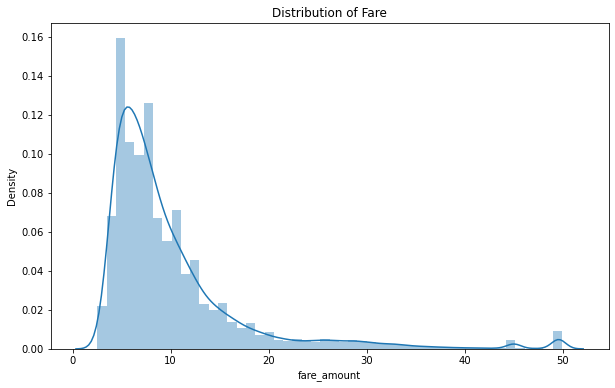

In [4]:
plt.figure(figsize = (10, 6))
sns.distplot(data['fare_amount']);
plt.title('Distribution of Fare');

### Remove Outliers

For visualization purposes, I'll create a binned version of the fare. This divides the variable into a number of bins, turning a continuous variable into a discrete, categorical variable.

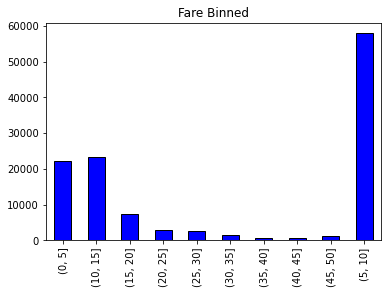

In [5]:
# Bin the fare and convert to string
data['fare-bin'] = pd.cut(data['fare_amount'], bins = list(range(0, 51, 5))).astype(str)


# Adjust bin so the sorting is correct
data.loc[data['fare-bin'] == '(0, 5]', 'fare-bin'] = '(0, 5]'

# Bar plot of value counts
data['fare-bin'].value_counts().sort_index().plot.bar(color = 'b', edgecolor = 'k');
plt.title('Fare Binned');

### Empirical Cumulative Distribution Function Plot

Another plot for showing the distribution of a single variable is the [empirical cumulative distribution function](https://en.wikipedia.org/wiki/Empirical_distribution_function). This shows the percentile on the y-axis and the variable on the x-axis and gets around some of the issues associated with binning data for histograms or the kernel width of the KDE.


In [6]:
def ecdf(x):
    """Empirical cumulative distribution function of a variable"""
    # Sort in ascending order
    x = np.sort(x)
    n = len(x)
    
    # Go from 1/n to 1
    y = np.arange(1, n + 1, 1) / n
    
    return x, y

Below is an example of the ecdf. This plot is good for viewing outliers and also the percentiles of a distribution.

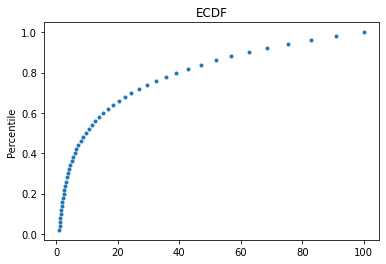

In [7]:
xs, ys = ecdf(np.logspace(0, 2))
plt.plot(xs, ys, '.');
plt.ylabel('Percentile'); plt.title('ECDF');

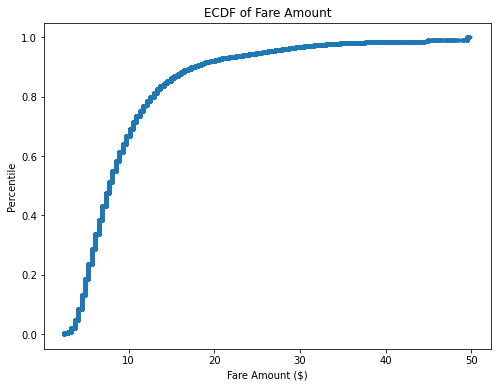

In [8]:
xs,ys = ecdf(data['fare_amount'])
plt.figure(figsize = (8, 6))
plt.plot(xs,ys, '.')
plt.ylabel('Percentile'); plt.title('ECDF of Fare Amount'); plt.xlabel('Fare Amount ($)');

This shows the distribution is heavily right skewed. Most of the fares are below \$20, with a heavy right tail of larger fares.

In [9]:
len(data[data['fare_amount'] > 25])/len(data)

0.053175

I will remove any fares greater than $25.

In [10]:
data = data[data['fare_amount'] <= 25]



#### Other Outliers

We can also remove observations based on outliers in other columns. First we'll make a graph of the passenger counts which seemed to have some suspicious values.

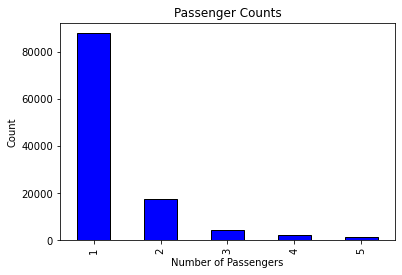

In [11]:
data['passenger_count'].value_counts().plot.bar(color = 'b', edgecolor = 'k');
plt.title('Passenger Counts'); plt.xlabel('Number of Passengers'); plt.ylabel('Count');

For the `latitude` and `longitude` columns, we can use statistics as well as our intuition for removing outliers. Here I'll find the 2.5% and 97.5% percentile values in each column and keep only measurements close to that range. 

In [12]:
print(f'Initial Observations: {data.shape[0]}')

Initial Observations: 113619


In [13]:
for col in ['pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude']:
    print(f'{col}: 2.5% = {round(np.percentile(data[col], 2.5), 2)} \t 97.5% = {round(np.percentile(data[col], 97.5), 2)}')

pickup_latitude: 2.5% = 40.71 	 97.5% = 40.8
pickup_longitude: 2.5% = -74.01 	 97.5% = -73.94
dropoff_latitude: 2.5% = 40.69 	 97.5% = 40.8
dropoff_longitude: 2.5% = -74.01 	 97.5% = -73.92


Based on these values, we can remove outliers. This is somewhat based on intuition and there might be a more accurate process for carrying out this operation! Here is another potential point for improvement:

* __Potential improvement 2: experiment with different methods to remove outliers.__ This could be through domain knowledge (such as using a map) or it could be using more rigorous statistical methods (such as z-scores).

Now we will graph the `latitude` and `longitude` columns to see the outliers. We'll just sample 30000 values so the plot doesn't take too long to generate.

C:\Users\Admin\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


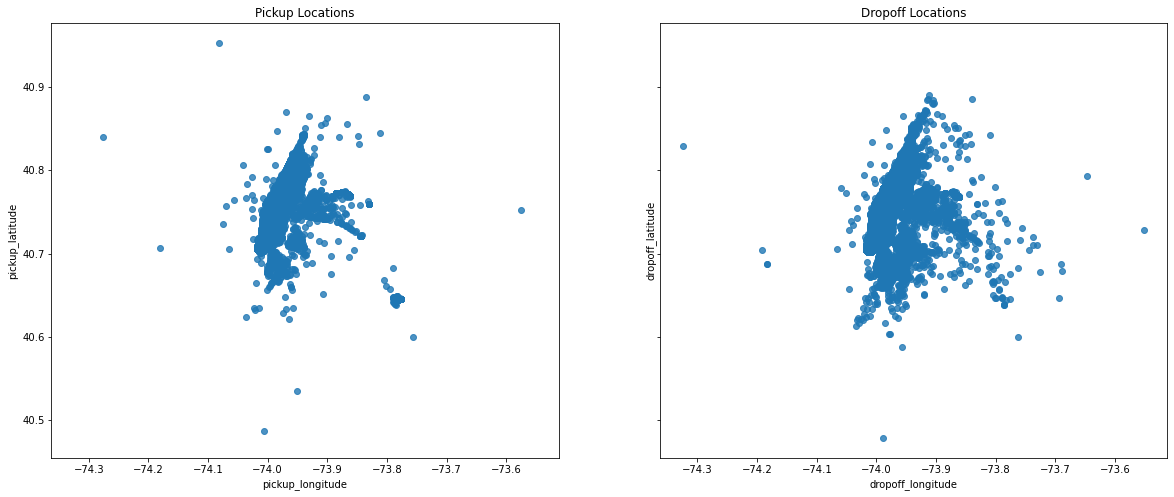

In [14]:
fig, axes = plt.subplots(1, 2, figsize = (20, 8), sharex=True, sharey=True)
axes = axes.flatten()

# Plot Longitude (x) and Latitude (y)
sns.regplot('pickup_longitude', 'pickup_latitude', fit_reg = False, 
            data = data.sample(30000, random_state = 0), ax = axes[0]);
sns.regplot('dropoff_longitude', 'dropoff_latitude', fit_reg = False, 
            data = data.sample(30000, random_state = 0), ax = axes[1]);
axes[0].set_title('Pickup Locations')
axes[1].set_title('Dropoff Locations');

In [15]:
# Remove latitude and longtiude outliers

data = data.loc[data['pickup_latitude'].between(40.71, 40.8)]

data = data.loc[data['pickup_longitude'].between(-74, -73.95)]

data = data.loc[data['dropoff_latitude'].between(40.7, 40.8)]

data = data.loc[data['dropoff_longitude'].between(-74.01, -73.93)]

print(f'New number of observations: {data.shape[0]}')

New number of observations: 81683


# Feature Engineering

Feature engineering is the process of creating features - predictor variables - out of a dataset. __Feature engineering is the most important step of the machine learning pipeline ([A Few Useful Things to Know about Machine Learning](https://homes.cs.washington.edu/~pedrod/papers/cacm12.pdf)).__ A model can only learn from the features it is given, and properly constructing features will determine how well your model performs.

Feature engineering involves domain expertise and experience on prior machine learning projects. A good place to start for Kaggle competitions is other kernels. Feel free to use, adapt, and build on other's work! 

### Relative Distances in Latitude and Longitude

As a simple first step of feature engineering, we can find the absolute value of the difference in latitude and longitude between the `pickup` and `dropoff`. While this does not represent an actual distance (we would have to convert coordinate systems), it can be used as a relative comparison of the distances of taxi rides. As the cost of a taxi ride is proportional to duration or distance, we would expect the relative distances to be a useful measure for estimating the fare. 

In [16]:
# Absolute difference in latitude and longitude
data['abs_lat_diff'] = (data['dropoff_latitude'] - data['pickup_latitude']).abs()
data['abs_lon_diff'] = (data['dropoff_longitude'] - data['pickup_longitude']).abs()

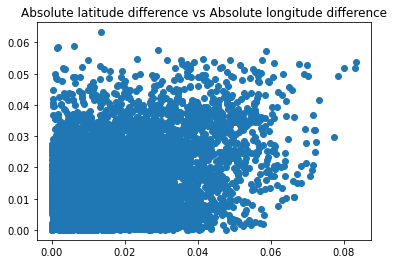

In [17]:
data1 = data.sample(10000, random_state=0)

plt.scatter(data1['abs_lat_diff'], data1['abs_lon_diff'])

plt.title('Absolute latitude difference vs Absolute longitude difference');

There do seem to be a few outliers, but I'll leave those in for now. We might also want to take a look if there are any observations where both the absolute differences are 0.

In [18]:
no_diff = data[(data['abs_lat_diff'] == 0) & (data['abs_lon_diff'] == 0)]
no_diff.shape

(0, 11)

C:\Users\Admin\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\Admin\anaconda3\lib\site-packages\seaborn\regression.py:580: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


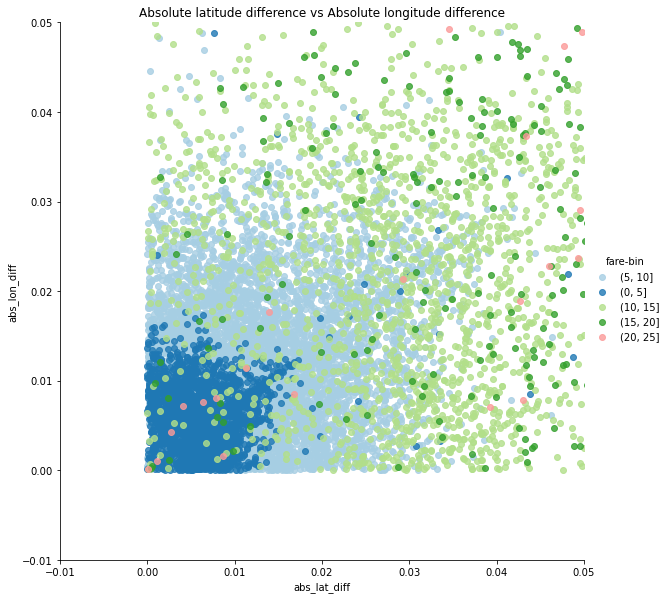

In [19]:
palette = sns.color_palette('Paired', 10)

sns.lmplot('abs_lat_diff', 'abs_lon_diff', hue = 'fare-bin', size = 8, palette = palette,
           fit_reg = False, data = data.sample(10000, random_state=0));

plt.xlim((-0.01, .05)); plt.ylim((-0.01, .05))
plt.title('Absolute latitude difference vs Absolute longitude difference');

It does seem that the rides with a larger absolute difference in both longitude and latitude tend to cost more. To capture both differences in a single variable, we can add up the two differences in latitude and longitude and also find the square root of the sum of differences squared. The former feature would be called the Manhattan distance - or l1 norm - and the latter is called the Euclidean distance - or l2 norm. Both of these distances are specific examples of the general Minkowski distance.

## Manhattan and Euclidean Distance

The [Minkowski Distance](https://en.wikipedia.org/wiki/Minkowski_distance) between two points is expressed as:

$${\displaystyle D\left(X,Y\right)=\left(\sum _{i=1}^{n}|x_{i}-y_{i}|^{p}\right)^{1/p}}$$

if p = 1, then this is the Manhattan distance and if p = 2 this is the Euclidean distance. You may also see these referred to as the l1 or l2 norm where the number indicates p in the equation. 

I should point out that these equations are only valid for actual distances in a [cartesian coordinate system](https://en.wikipedia.org/wiki/Cartesian_coordinate_system) and here we only use them to find relative distances. To find the actual distances in terms of kilometers, we have to work with the latitude and longitude [geographical coordinate system](https://en.wikipedia.org/wiki/Geographic_coordinate_system). This will be done later using the Haversine formula.

In [20]:
def minkowski_distance(x1, x2, y1, y2, p):
    return ((abs(x2 - x1) ** p) + (abs(y2 - y1)) ** p) ** (1 / p)

Manhattan distance

In [21]:
minkowski_distance(0, 3, 0, 4, 1)

7.0

Here's the same as a Euclidean distance which is the length of a straight line connecting the points.

In [22]:
minkowski_distance(0, 3, 0, 4, 2)

5.0

Let's apply this function to the latitude and longitudes. Again, this does not represent an absolute distance because we would need to convert coordinate systems. However, these features are useful as _relative_ comparisons between rides.

In [23]:
# Create a color mapping based on fare bins
color_mapping = {fare_bin: palette[i] for i, fare_bin in enumerate(data['fare-bin'].unique())}
color_mapping

{'(5, 10]': (0.6509803921568628, 0.807843137254902, 0.8901960784313725),
 '(10, 15]': (0.12156862745098039, 0.47058823529411764, 0.7058823529411765),
 '(0, 5]': (0.6980392156862745, 0.8745098039215686, 0.5411764705882353),
 '(15, 20]': (0.2, 0.6274509803921569, 0.17254901960784313),
 '(20, 25]': (0.984313725490196, 0.6039215686274509, 0.6)}

In [24]:
data['color'] = data['fare-bin'].map(color_mapping)

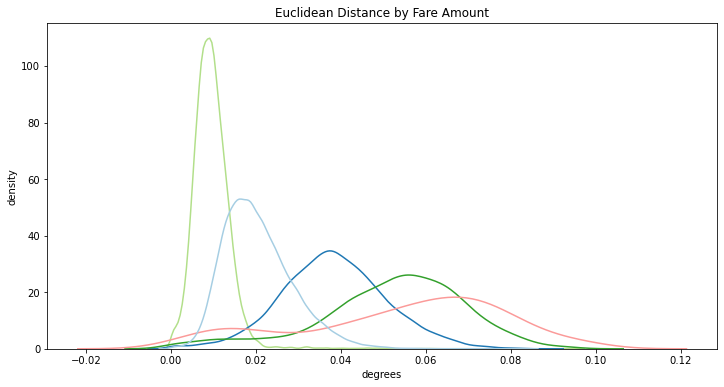

In [25]:
data['euclidean'] = minkowski_distance(data['pickup_longitude'], data['dropoff_longitude'],
                                       data['pickup_latitude'], data['dropoff_latitude'], 2)

# Calculate distribution by each fare bin
plt.figure(figsize = (12, 6))
for f, grouped in data.groupby('fare-bin'):
    sns.kdeplot(grouped['euclidean'], label = f'{f}', color = list(grouped['color'])[0]);

plt.xlabel('degrees'); plt.ylabel('density')
plt.title('Euclidean Distance by Fare Amount');

These features do seem to have some differences between the different fare amounts, so they might be helpful in predicting the fare. 

In [26]:
data.groupby('fare-bin')['euclidean'].agg(['mean', 'count'])

,mean,count
fare-bin,,
"(0, 5]",0.009638,18201
"(10, 15]",0.038339,14578
"(15, 20]",0.052074,2411
"(20, 25]",0.054059,385
"(5, 10]",0.020532,46108


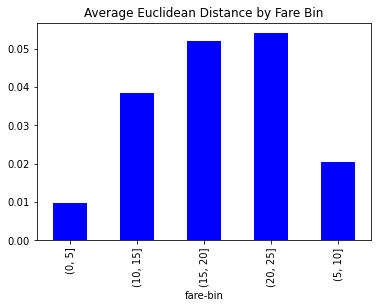

In [27]:
data.groupby('fare-bin')['euclidean'].mean().plot.bar(color = 'b');
plt.title('Average Euclidean Distance by Fare Bin');

There is a very clearly relationship between the fare bin and the average distance of the trip! This should give us confidence that this feature will be useful to a model.

Another plot we can make is the passenger count distribution colored by the fare bin.

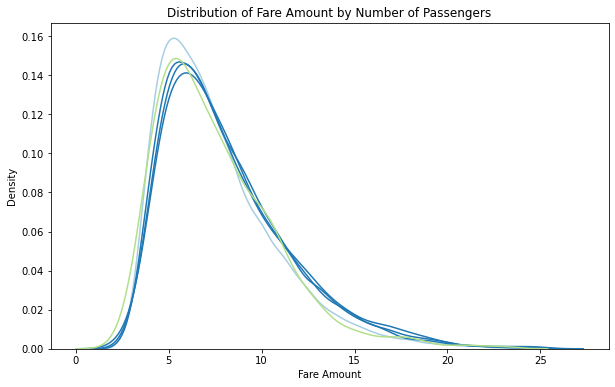

In [28]:
plt.figure(figsize = (10, 6))

for p, grouped in data.groupby('passenger_count'):
    sns.kdeplot(grouped['fare_amount'], label = f'{p} passengers', color = list(grouped['color'])[0]);
    
plt.xlabel('Fare Amount'); plt.ylabel('Density')
plt.title('Distribution of Fare Amount by Number of Passengers');

There does not appear to be much difference between the number of passengers. To get a more accurate picture, we can calculate the actual stats.

In [29]:
data.groupby('passenger_count')['fare_amount'].agg(['mean', 'count'])

,mean,count
passenger_count,,
1,7.593987,63587
2,8.003574,12303
3,8.117157,3233
4,8.243154,1677
5,7.579049,883


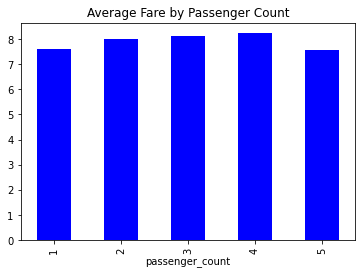

In [30]:
data.groupby('passenger_count')['fare_amount'].mean().plot.bar(color = 'b');
plt.title('Average Fare by Passenger Count');

There is a small but noticeable difference in the average fare by the number of passengers.



As a final step, we can find the correlations between distances and fares.

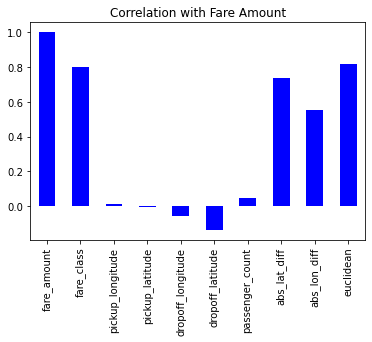

In [31]:
corrs = data.corr()
corrs['fare_amount'].plot.bar(color = 'b');
plt.title('Correlation with Fare Amount');

All the measures of distance have a _positive_ linear correlation with the fare, indicating that as they increase, the fare tends to increase as well. 

The correlation coefficient measures the strength and direction of a linear relationship. Because the linear relationship with the target variable is so strong, we may be able to just use a linear model (regression) to accurately predict the fares. 

# Machine Learning

Now that we have built a few potentially useful features, we can use them for machine learning: training an algorithm to predict the target from the features. We'll start off with a basic model - Linear Regression - only using a few features and then move on to a more complex models and more features. There is reason to believe that for this problem, even a simple linear model will perform well because of the strong linear correlation of the distances with the fare. We generally want to use the simplest - and hence most interpretable - model that is above an accuracy threshold (dependent on the application) so if a linear model does the job, there's no need to use a highly complex ensemble model. It's a best practice to start out with a simple model for just this reason! 


## First Model: Linear Regression

The first model we'll make is a simple linear regression using 3 features: the `abs_lat_diff`, `abs_lon_diff`, and `passenger_count`. This is meant to serve as a baseline for us to beat.

It's good to start with a simple model because it will give you a baseline. Also, if a simple model works well enough, then there may be no need for more complex models. If a linear regression will get the job done, then you don't need a neural network!

In [32]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

lr = LinearRegression()

## Create Training and Validation Set

We'll want to create a training and separate validation set to assess our model. Ideally, we only use the test set once, to evaluate the final model. We can make a validation set with 1 million observations to estimate our performance.

We __stratify__ the split using the `fare-bin`. This ensures that the training and validation set have the same distribution of fare bins. This is important for imbalanced classification problems, but it can also be useful for regression problems so we don't end up with a lot of outliers in terms of the target in either the validation or training set. (We have to stratify based on a discrete variable which is why we use the fare bin.)

In [33]:
# Split data
X_train, X_valid, y_train, y_valid = train_test_split(data, np.array(data['fare_amount']), 
                                                      stratify = data['fare-bin'],
                                                      random_state = 0, test_size = 10000)

### Train with Simple Features

We'll train the linear regression using three features. The benefit of the linear regression is that it's interpretable: we can inspect the coefficients and intercept.

In [34]:
lr.fit(X_train[['abs_lat_diff', 'abs_lon_diff', 'passenger_count']], y_train)

print('Intercept', round(lr.intercept_, 4))
print('abs_lat_diff coef: ', round(lr.coef_[0], 4), 
      '\tabs_lon_diff coef:', round(lr.coef_[1], 4),
      '\tpassenger_count coef:', round(lr.coef_[2], 4))

Intercept 3.6021
abs_lat_diff coef:  157.1945 	abs_lon_diff coef: 105.1845 	passenger_count coef: 0.1386


In all cases, the coefficient is positive, indicating a larger value of the variable corresponds to a larger fare according to the model. We can say that according to a linear model, for every 1 more passenger, the fare increases by \$0.1321. The `intercept` indicates the fare that would be predicted if there is no latitude or longitude difference and the passenger count is 0.

#### Score Model

Here we use the validation set for assessing the model. We'll use two metrics:

* __Root mean squared error__: the metric used by the competition
* __Mean absolute percentage error__: the average percentage error of the predictions

I like using the mean absolute percentage error (MAPE) because it's often more interpretable. 

In [35]:
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings('ignore', category = RuntimeWarning)

def metrics(train_pred, valid_pred, y_train, y_valid):
    """Calculate metrics:
       Root mean squared error and mean absolute percentage error"""
    
    # Root mean squared error
    train_rmse = np.sqrt(mean_squared_error(y_train, train_pred))
    valid_rmse = np.sqrt(mean_squared_error(y_valid, valid_pred))
    
    # Calculate absolute percentage error
    train_ape = abs((y_train - train_pred) / y_train)
    valid_ape = abs((y_valid - valid_pred) / y_valid)
    
    train_mape = 100 * np.mean(train_ape)
    valid_mape = 100 * np.mean(valid_ape)
    
    return train_rmse, valid_rmse, train_mape, valid_mape

def evaluate(model, features, X_train, X_valid, y_train, y_valid):
    """Mean absolute percentage error"""
    
    # Make predictions
    train_pred = model.predict(X_train[features])
    valid_pred = model.predict(X_valid[features])
    
    # Get metrics
    train_rmse, valid_rmse, train_mape, valid_mape = metrics(train_pred, valid_pred,
                                                             y_train, y_valid)
    
    print(f'Training:   rmse = {round(train_rmse, 2)} \t mape = {round(train_mape, 2)}')
    print(f'Validation: rmse = {round(valid_rmse, 2)} \t mape = {round(valid_mape, 2)}')

In [36]:
evaluate(lr, ['abs_lat_diff', 'abs_lon_diff', 'passenger_count'], 
        X_train, X_valid, y_train, y_valid)

Training:   rmse = 1.97 	 mape = 18.59
Validation: rmse = 1.99 	 mape = 18.59


Without anything to compare these results to, we can't say if they are good. This is the reason for establishing a basic baseline with no machine learning!

### Naive Baseline

To make sure that machine learning is even applicable to the task, we should compare these predictions to a naive guess. For a regression task, this can be as simple as the average value of the target in the training data.

In [37]:
train_mean = y_train.mean()

# Create list of the same prediction for every observation
train_preds = [train_mean for _ in range(len(y_train))]
valid_preds = [train_mean for _ in range(len(y_valid))]

tr, vr, tm, vm = metrics(train_preds, valid_preds, y_train, y_valid)

print(f'Baseline Training:   rmse = {round(tr, 2)} \t mape = {round(tm, 2)}')
print(f'Baseline Validation: rmse = {round(vr, 2)} \t mape = {round(vm, 2)}')

Baseline Training:   rmse = 3.26 	 mape = 37.31
Baseline Validation: rmse = 3.26 	 mape = 37.4


According to the naive baseline, our machine learning solution is effective! We are able to reduce the percentage error by about half and generate much better predictions than using no machine learning. This should give us confidence we are on the right track.

## Use More Features

While the first model scored well relative to the baseline, there is much room for improvement. As a first step, let's use one of the other features we created, the `euclidean` distance.

In [38]:
lr.fit(X_train[['euclidean', 'abs_lat_diff', 'abs_lon_diff', 'passenger_count']], y_train)

evaluate(lr, ['euclidean', 'abs_lat_diff', 'abs_lon_diff', 'passenger_count'], 
         X_train, X_valid, y_train, y_valid)

Training:   rmse = 1.81 	 mape = 16.1
Validation: rmse = 1.82 	 mape = 16.07


In [39]:
print(lr.intercept_)
print(lr.coef_)

3.160194612742833
[ 3.80445103e+02 -1.34550932e+02 -1.51142325e+02  1.26026128e-01]


Using this one more feature improved our score slightly. Here's another chance for improvement using the same model:

* __Potential Improvement 3: find an optimal set of features or construct more features__. This can involve [feature selection](http://scikit-learn.org/stable/modules/feature_selection.html) or trying different combinations of features and evaluating them on the validation data. You can build additional features by looking at others' work or researching the problem.

#### Collinear Features

One thing we do want to be careful about is highly correlated, known as [collinear](https://en.wikipedia.org/wiki/Multicollinearity), features. These can decrease the generalization performance of the model and lead to less interpretable models. Many of our features are already highly correlated as shown in the heatmap below. This plots the Pearson Correlation Coefficient for each pair of variables.

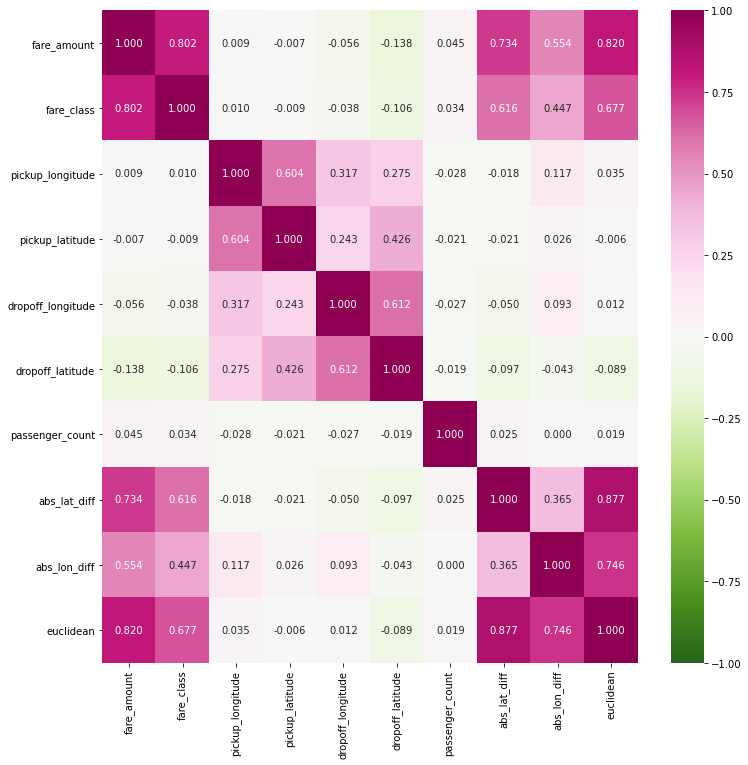

In [40]:
corrs = data.corr()

plt.figure(figsize = (12, 12))
sns.heatmap(corrs, annot = True, vmin = -1, vmax = 1, fmt = '.3f', cmap=plt.cm.PiYG_r);

You might not want to use two variables that are very highly correlated with each other (such as `euclidean` and `haversine`) because of issues with interpretability and performance.

# Upgraded Model

When we want to improve performance, we generally have a few options:

1. Get more data - either more observations or more variables
2. Engineer more / better features
3. Perform feature selection to remove irrelevant features
4. Try a more complex model
5. Perform hyperparameter tuning of the selected model

We already saw that including another feature could improve perfomance. For now let's move past the features and focus on the model (we'll come back to features later).

The simple linear regression has no hyperparameters to optimize (no settings to tune) so we'll try approach 4. If the more complex model does well, we can use it for testing additional features or performing feature selection

## Non-Linear Model: Random Forest

For a first non-linear model, we'll use the [Random Forest](https://medium.com/p/77bf308a9b76?source=user_profile---------3------------------) regressor. This is a powerful ensemble of regression trees that has good performance and generalization ability because of its low variance. We'll use most of the default hyperparameters but change the `n_estimators` and the `max_depth` of each tree in the forest. For the features, we'll use the four features which delivered good performance in the linear regression.

In [41]:
from sklearn.ensemble import RandomForestRegressor

# Create the random forest
random_forest = RandomForestRegressor(n_estimators = 100, max_depth = 10, 
                                      max_features = None, oob_score = True, 
                                      bootstrap = True, verbose = 1, n_jobs = -1)

# Train on data
random_forest.fit(X_train[['euclidean', 'abs_lat_diff', 'abs_lon_diff', 'passenger_count']], y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    8.2s finished


RandomForestRegressor(max_depth=10, max_features=None, n_jobs=-1,
                      oob_score=True, verbose=1)

In [42]:
evaluate(random_forest, ['euclidean', 'abs_lat_diff', 'abs_lon_diff', 'passenger_count'],
         X_train, X_valid, y_train, y_valid)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s


Training:   rmse = 1.64 	 mape = 15.06
Validation: rmse = 1.8 	 mape = 15.82


[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.0s finished


The random forest does much better than the simple linear regression. This indicates that the problem is not completely linear, or at least is not linear in terms of the features we have constructed. From here going forward, we'll use the same random forest model because of the increased performance. 

# More Features

Now that we've decided on the Random Forest as our model, we can try using additional features. Let's see what happens when we use 8 of the features for training. The function below trains the random forest and assesses it on the validation data.

In [43]:
def model_rf(X_train, X_valid, y_train, y_valid, data, features,
             model = RandomForestRegressor(n_estimators = 100,
                                           n_jobs = -1),
             return_model = False):
    """Train and evaluate the random forest using the given set of features."""
    
    # Train
    model.fit(X_train[features], y_train)
    
    # Make predictions on test and generate submission dataframe
    preds = model.predict(data[features])
    
    # Extract feature importances
    feature_importances = pd.DataFrame({'feature': features,
                                        'importance': model.feature_importances_}).\
                           sort_values('importance', ascending = False).set_index('feature')
    
    
    return  feature_importances

In [44]:
data.columns

Index(['pickup_datetime', 'fare_amount', 'fare_class', 'pickup_longitude',
       'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude',
       'passenger_count', 'fare-bin', 'abs_lat_diff', 'abs_lon_diff', 'color',
       'euclidean'],
      dtype='object')

In [45]:
# Evaluate using 8 features
model_rf(X_train, X_valid, y_train, y_valid,data, 
                   features = ['abs_lat_diff', 'abs_lon_diff', 'euclidean', 'passenger_count',
                               'pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude'])

,importance
feature,
euclidean,0.693390
abs_lat_diff,0.070377
abs_lon_diff,0.051403
dropoff_latitude,0.049129
dropoff_longitude,0.046517
pickup_latitude,0.042248
pickup_longitude,0.039372
passenger_count,0.007564


It appears that using more features helps the model! We can look at the feature importances to see which the model considers "most relevant".

#### Feature Importances

The `euclidean` distance is by far the most important with the other features showing considerably less relevance to the model. This suggests that distance is key, and we might want to find a more accurate way of calculating distances.

# FINAL

In [46]:
features = ['abs_lat_diff', 'abs_lon_diff', 'euclidean', 
                               'pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude']

model = RandomForestRegressor(n_estimators = 200)

model.fit(X_train[features], y_train)

evaluate(model, features , 
         X_train, X_valid, y_train, y_valid)

Training:   rmse = 0.64 	 mape = 5.62
Validation: rmse = 1.74 	 mape = 15.14


In [50]:
features = ['euclidean']
model = RandomForestRegressor(n_estimators = 100)

model.fit(X_train[features], y_train)

evaluate(model, features , 
         X_train, X_valid, y_train, y_valid)

Training:   rmse = 1.0 	 mape = 9.03
Validation: rmse = 2.26 	 mape = 20.73
